# 9.4 Optimising with Numba

*Estimated time for this notebook: 15 minutes*

We saw that we can use Cython to get an approximate 40x speed up when compared to pure Python.
However, this comes with the cost of having to substantially rewrite the Python code.
An alternative is to use [numba](https://numba.pydata.org/), an open source just-in-time compiler that translates a subset of Python and NumPy code into fast machine code.

## 9.4.0 Define a Pure Python Function

Let's start by reproducing the pure-Python implementation from earlier.

In [1]:
xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]

In [2]:
def mandel(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum 
    number of iterations.
    
    Returns the number of iterations.
    """
    
    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter


assert mandel(0) == 50
assert mandel(3) == 1
assert mandel(0.5) == 5

In [3]:
%%timeit

[[mandel(x + 1j* y) for x in xs] for y in ys]

412 ms ± 15.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 9.4.1 The @njit Decorator

Now let's look at a numba implementation for a single value.
We add a Numba decorator to the pure-Python implementation.
Note that ```@njit``` is equivalent to ```@jit(nopython=True)```.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from numba import njit

In [5]:
@njit
def mandel_numba(constant, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations. 
    
    The function stops when the absolute value of the series surpasses 2 or when it reaches the maximum 
    number of iterations.
    
    Returns the number of iterations.
    """
    
    value = 0

    counter = 0
    while counter < max_iterations:
        if abs(value) > 2:
            break

        value = (value * value) + constant

        counter = counter + 1

    return counter

Note that `numba` will compile the function the first time we invoke it, so the first call will be notably slower than the rest.

In [6]:
%%timeit -r 1 -n 1

mandel_numba(complex(0, 0))

259 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
# Run after our first, timed, invocation
assert mandel_numba(0) == 50
assert mandel_numba(3) == 1
assert mandel_numba(0.5) == 5

In [8]:
%%timeit

[[mandel_numba(x + 1j* y) for x in xs] for y in ys]

39.6 ms ± 721 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This provides an approximately 10x increase in performance compared to the pure-Python implementation.

In [9]:
data_numba = [[mandel_numba(complex(x, y)) for x in xs] for y in ys]

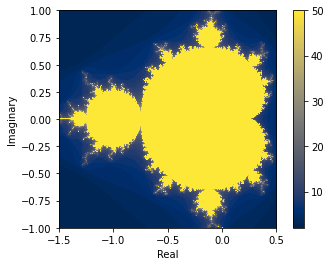

In [10]:
plt.set_cmap("cividis")  # use a color vision deficiency-friendly palette
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    data_numba,
    interpolation="none",
    extent=[xmin, xmax, ymin, ymax],
    origin="lower"
)
plt.colorbar()

## 9.4.2 Parallelisation with Multiprocessing

Modern CPUs have more than one core. You can find out how many there are on your machine with

In [11]:
from os import cpu_count
cpu_count()

12

Python's [multiprocessing library](https://docs.python.org/3/library/multiprocessing.html) works better with `.py` files than notebooks so we'll write our slow function to file.

In [12]:
%%writefile sleeping.py

from time import sleep

def square(argument):
    sleep(0.5)
    return argument * argument

Overwriting sleeping.py


If we change the cell above, we'll need to `reload()` the `sleeping` module.

In [13]:
import sleeping

import importlib
importlib.reload(sleeping)

<module 'sleeping' from '/Users/istenson/code/turing/rse-course/module09_programming_for_speed/sleeping.py'>

We can apply our `square()` function to each element in a list with `map()`. `map()` returns an iterator so we use `list()` to get all of the results as a list, for comparison.

In [14]:
assert list(map(sleeping.square, [0, 1, 2, 3])) == [0, 1, 4, 9]

`square()` sleeps for 0.5 second each time it is called so calling it 8 times should take around 4 seconds.

In [15]:
%%timeit -n 2 -r 2

list(map(sleeping.square, [0, 1, 2, 3, 4, 5, 6, 7, 8]))

4.53 s ± 2.99 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


We can make use of our other CPU cores by creating a pool of processes and assigning some work to each. By default, `Pool()` will make one worker process for each core on the machine.

You can use `Pool` as a context manager...

In [16]:
from multiprocessing import Pool
with Pool() as pool:
    results = pool.map(
        sleeping.square,
        [1, 2, 3, 4, 5, 6, 7, 8]
    )
results

[1, 4, 9, 16, 25, 36, 49, 64]

...or you can assign it on the same line as `%%timeit` so that the time taken to create the pool doesn't count towards the performance timing.

In [17]:
%%timeit pool = Pool()

pool.map(sleeping.square, [1, 2, 3, 4, 5, 6, 7, 8])

564 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note that processing all 8 elements now only takes a little over 0.5s.

If you don't use the context manager, you should remember to close the pool.

In [18]:
pool.close()

Go to notebook **9.6 Classroom Exercises** and do *Exercise 9d*.

## 9.4.3 Parallelisation with numba

Similarly to `numpy`, `numba` has optimisations related to parallelisation.
Let's see whether we can improve on the performance of `mandel_cython_numpy`, the best Cython solution we found earlier.
If we are certain that there are no dependencies between different elements in a range, we can parallelize iteration by using the `prange` function.

In [19]:
from numba import prange
help(prange)

Help on class prange in module numba.misc.special:

class prange(builtins.object)
 |  prange(*args)
 |  
 |  Provides a 1D parallel iterator that generates a sequence of integers.
 |  In non-parallel contexts, prange is identical to range.
 |  
 |  Static methods defined here:
 |  
 |  __new__(cls, *args)
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [20]:
@njit(parallel=True)
def mandel_numba_parallel(constants, max_iterations=50):
    """Computes the values of the series for up to a maximum number of iterations.
    
    Returns the number of iterations.
    """
    xlim = constants.shape[1]
    ylim = constants.shape[0]
    
    diverged_at_count = np.zeros((ylim, xlim))
    
    for y in prange(ylim):
        for x in prange(xlim):
            
            value = 0
            counter = 0
            
            while counter < max_iterations:
                if abs(value) > 2:
                    break

                value = (value * value) + constants[y, x]

                counter = counter + 1
            
            diverged_at_count[y, x] = counter

    return diverged_at_count


In [21]:
assert mandel_numba_parallel(np.asarray([[0]])) == np.asarray([[50]])
assert mandel_numba_parallel(np.asarray([[4]])) == np.asarray([[1]])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [22]:
cs_listcomp = [[(x + y*1j) for x in xs] for y in ys]
cs = np.asarray(cs_listcomp)

In [23]:
%%timeit
mandel_numba_parallel(cs)

2.29 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
zs = mandel_numba_parallel(cs)

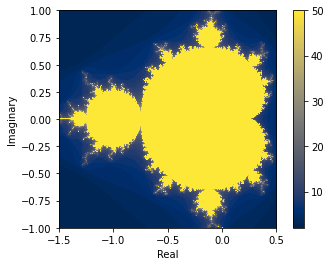

In [25]:
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    zs,
    interpolation="none",
    extent=[xmin, xmax, ymin, ymax],
    origin="lower"
)
plt.colorbar()

We see that allowing numba to use all of our CPU cores has increased the performance with relatively few code changes. The best possible speedup with parallelisation with be a factor of `cpu_count()` but this often won't be realised in practice.

More on optimising with numba in notebook **9.8 Self study**.